# Introduction

Now that we've downloaded the data can we generate the plots? Fairlie's looking for A, B, and the log2 aligned plot from 

<img src="panel-to-replicate.png" width="60%" />

In [1]:
from Bio import SeqIO
from matplotlib import pyplot
import numpy
from pathlib import Path
import pandas
import pysam
from tqdm import tqdm
from xopen import xopen

In [2]:
experiments = pandas.read_csv("cached_experiments.tsv", sep="\t")

In [3]:
target = experiments.iloc[0]["target"]
target

'cache/ENCSR293MOX_1_1_ENCFF318SKH_reads.fastq.gz'

In [4]:
def score_aligned_reads(filename):
    with pysam.AlignmentFile(filename, "rb") as inbam:
        aligned_reads = 0
        aligned_query_len = []
        aligned_positions = []

        for read in inbam:
            if not read.is_unmapped:
                aligned_reads += 1
                aligned_query_len.append(read.query_length)
                aligned_positions.append(len(read.positions))

        #aligned_query_len = numpy.asarray(aligned_query_len)
        #aligned_positions = numpy.asarray(aligned_positions)
        return {
            "aligned_reads": len(aligned_query_len),
            "query_len_median": numpy.median(aligned_query_len),
            "query_len": aligned_query_len,
            "positions_median": numpy.median(aligned_positions),
            "positions_len": aligned_positions,
        }

#score_aligned_reads(target)

In [5]:
def score_fastq_reads(filename):
    read_len = []
    with xopen(filename, "rt") as instream:
        for record in SeqIO.parse(instream, "fastq"):
            read_len.append(len(record))
    
    return {
        "raw_reads": len(read_len),
        "read_len_median": numpy.median(read_len),
        "read_len": read_len,
    }

#score_fastq_reads("cache/ENCSR293MOX_1_1_ENCFF318SKH_reads.fastq.gz")


In [6]:
counts = {}
for i, row in tqdm(experiments.iterrows(), total=experiments.shape[0]):
    name = "{}_{}".format(row["experiment"], row["tech_rep"])
    if row.output_type == "unfiltered alignments":
        result = score_aligned_reads(row["target"])
    elif row.output_type == "reads":
        result = score_fastq_reads(row["target"])
    else:
        raise ValueError("Unrecognized output type {} in row {}".format(row.output_type, i))

    counts.setdefault(name, {}).update(result)

100%|██████████| 276/276 [8:04:17<00:00, 105.28s/it]  


In [34]:
counts.keys()

dict_keys(['ENCSR293MOX_1_1', 'ENCSR081NRO_1_1', 'ENCSR257JBF_1_1', 'ENCSR257JBF_1_2', 'ENCSR838WFC_1_1', 'ENCSR838WFC_2_1', 'ENCSR902GAF_3_1', 'ENCSR902GAF_1_1', 'ENCSR902GAF_2_1', 'ENCSR181CES_1_1', 'ENCSR676IWT_1_1', 'ENCSR676IWT_1_2', 'ENCSR995WKW_1_1', 'ENCSR904KAT_1_1', 'ENCSR904KAT_2_1', 'ENCSR113MEY_1_1', 'ENCSR589FUJ_2_1', 'ENCSR589FUJ_1_1', 'ENCSR388RWE_1_1', 'ENCSR194YUY_1_1', 'ENCSR706ANY_1_1', 'ENCSR706ANY_2_1', 'ENCSR706ANY_3_1', 'ENCSR706ANY_4_1', 'ENCSR634AKC_1_1', 'ENCSR127HKN_1_1', 'ENCSR127HKN_2_1', 'ENCSR127HKN_3_1', 'ENCSR130CIK_1_1', 'ENCSR130CIK_2_1', 'ENCSR044ARQ_1_1', 'ENCSR044ARQ_2_1', 'ENCSR296PQZ_1_1', 'ENCSR296PQZ_2_1', 'ENCSR810XLL_1_1', 'ENCSR526TQU_1_1', 'ENCSR947JHA_1_1', 'ENCSR962BVU_1_1', 'ENCSR530BOC_1_1', 'ENCSR530BOC_2_1', 'ENCSR271KEJ_1_1', 'ENCSR271KEJ_2_1', 'ENCSR271KEJ_3_1', 'ENCSR887LTD_1_1', 'ENCSR887LTD_2_1', 'ENCSR983KDL_1_1', 'ENCSR983KDL_2_1', 'ENCSR148IIG_1_1', 'ENCSR148IIG_1_2', 'ENCSR834DQL_1_1', 'ENCSR834DQL_2_1', 'ENCSR056MYH_1_1', '

In [35]:
counts["ENCSR293MOX_1_1"].keys()

dict_keys(['raw_reads', 'read_len_median', 'read_len', 'aligned_reads', 'query_len_median', 'query_len', 'positions_median', 'positions_len'])

In [38]:
array_attributes = ["read_len", "query_len", "positions_len"]
lengths = {}

medians = {}
for name in counts:
    for k in counts[name]:
        if k in array_attributes:
            lengths[(k, name)] = counts[name][k]
        else:
            medians.setdefault(k, {})[name] = counts[name][k]

#various_counts = pandas.DataFrame({k: count[k] for k in count if k not in array_attributes}).T

Table of just has the counts, and not the list of every read

In [12]:
various_counts = pandas.DataFrame(medians)
various_counts

,raw_reads,read_len_median,aligned_reads,query_len_median,positions_median
ENCSR293MOX_1_1,690170,912.0,727693,915.0,891.0
ENCSR081NRO_1_1,856966,1240.0,916397,1237.0,1168.0
ENCSR257JBF_1_1,722117,1404.0,766001,1404.0,1337.0
ENCSR257JBF_1_2,775345,1431.0,824096,1434.0,1393.0
ENCSR838WFC_1_1,2137168,1567.0,2148933,1561.0,1551.0
...,...,...,...,...,...
ENCSR463IDK_1_1,2255491,1426.0,2301028,1390.0,1364.0
ENCSR316ZTD_1_1,2796483,1467.0,2827850,1427.0,1410.0
ENCSR462COR_1_1,3152341,1176.0,3075099,1142.0,1129.0
ENCSR257YUB_1_1,2904443,1496.0,2961851,1453.0,1432.0


In [47]:
various_counts.to_csv("all_summary_counts.tsv", sep="\t")

# Raw versus Aligned read count

Plot number of raw reads versus number of aligned reads. Each dot is an individual library.

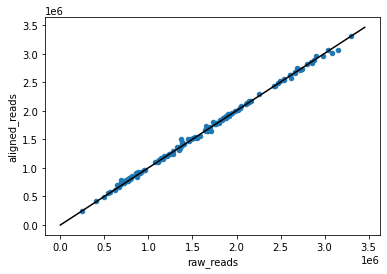

In [22]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
various_counts.plot.scatter(x="raw_reads", y="aligned_reads", ax=ax)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
_ = ax.plot([0,xmax], [0,ymax], color='k')

# Median raw reads versus query length

Plot median raw read length versus the query sequence length of reads that were aligned successfully.

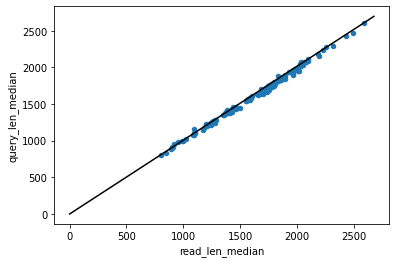

In [23]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
various_counts.plot.scatter(x="read_len_median", y="query_len_median", ax=ax)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
_ = ax.plot([0,xmax], [0,ymax], color='k')

# Median raw reads versus just the aligned part of aligned reads

Plot the median raw read length versus median length of positions of the read aligned to the reference genome. (This should be shorter than query length because sometimes some of the read is primers or other junk that doesn't get aligned, or there's something in our sample that's not in the reference.)

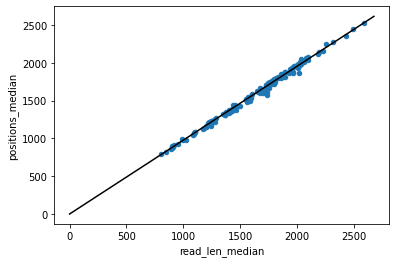

In [24]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
various_counts.plot.scatter(x="read_len_median", y="positions_median", ax=ax)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
_ = ax.plot([0,xmax], [0,ymax], color='k')

In [57]:
def get_positions(lengths):
    for key in tqdm(lengths):
        if key[0] == "positions_len":
            yield from lengths[key]
            
all_positions_len = pandas.Series(get_positions(lengths))
all_positions_len = numpy.log2(all_positions_len)
        

100%|██████████| 414/414 [00:21<00:00, 18.90it/s]


# Plot KDE of positions aligned to genome

(So very slow)

<AxesSubplot:ylabel='Density'>

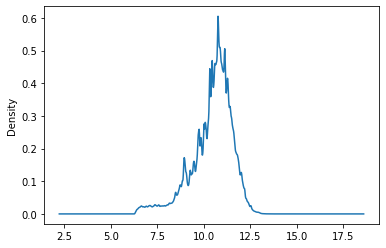

In [58]:
all_positions_len.plot.kde()

# Dump the collection of every read length to a compressed tsv file.

format is:

- type of lengths
- experiment id_replicates
- number of records in list
- comma separated list of lengths.

This is not a data frame because the different files have different number of records.

In [50]:
with xopen("all_read_lengths.tsv.gz", "wt") as outstream:
    outstream.write("\t".join(["name", "experiment_id", "N", "values"]))
    outstream.write("\n")
    for key in tqdm(lengths):
        outstream.write("\t".join(key))
        outstream.write("\t")
        outstream.write("{}".format(len(lengths[key])))
        outstream.write("\t")
        outstream.write(",".join((str(x) for x in lengths[key])))
        outstream.write("\n")


100%|██████████| 414/414 [04:47<00:00,  1.44it/s]
